In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))  

In [2]:
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
from agents.fairy.util import get_groq_llm_lc
from langchain_core.messages import HumanMessage, SystemMessage
from agents.fairy.fairy_state import FairyDungeonIntentOutput
from enums.LLM import LLM

expect_multi_question = "HP 포션좀 먹고 싶어, 물약좀 먹으면서 저 슬라임 공략법에 대해 알려줘"
expect_monster = "저거 공략법좀 알려줘"
expect_event = "이 석상을 부시면 어떻게 되는거야?"
expect_navigator= "현재 방에서 어디로 가야돼?"
expect_interaction_handler = "방 불좀 켜줘"
expect_small_talk = "심심행"
expect_unknown_intent = "al;sdas 내가 낀 아이템을 사용해"
expect_game_system = "게임 어떻게 꺼?"

expect_super_multi = "내가 낀 아이템을 사용해 그리고 저 몬스터 공략법좀 알려줘 그리고 이 석상을 어떻게 부셔? 다음 던전 방에는 뭐고? 그리고 심심해 그리고 게임 어떻게 종료해?"

system_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_INTENT).get_prompt()
messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content="뭙야")
] 

parser_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=43).with_structured_output(FairyDungeonIntentOutput)
result = parser_llm.invoke(messages)
print(result)

/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/main.py:250: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


intents=[<FairyDungeonIntentType.SMALLTALK: 'SMALLTALK'>]


In [3]:
%%writefile fairy_dungeon_agent.py
from agents.fairy.fairy_state import (
    FairyDungeonIntentOutput,
    FairyDungeonState,
    FairyDungeonIntentType,
)
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import interrupt
from agents.fairy.cache_data import reverse_questions, GAME_SYSTEM_INFO
from prompts.promptmanager import PromptManager
from prompts.prompt_type.fairy.FairyPromptType import FairyPromptType
import random, asyncio
from agents.fairy.util import (
    add_ai_message,
    add_human_message,
    str_to_bool,
    get_groq_llm_lc,
    find_monsters_info,
)
from core.common import get_inventory_items
from enums.LLM import LLM
from langchain.chat_models import init_chat_model
from typing import List
from db.RDBRepository import RDBRepository
from db.rdb_entity.DungeonRow import DungeonRow
from agents.fairy.dynamic_prompt import dungeon_spec_prompt

intent_llm = get_groq_llm_lc(model=LLM.LLAMA_3_1_8B_INSTANT, max_token=43)
action_llm = get_groq_llm_lc(max_token=80)
small_talk_llm = init_chat_model(model=LLM.GROK_4_FAST_NON_REASONING)
rdb_repository = RDBRepository()

async def get_monsters_info(target_monster_ids: List[int]):
    return find_monsters_info(target_monster_ids)


async def get_event_info(dungeon_row: DungeonRow, curr_room_id: int):
    curr_room_id
    return dungeon_row.event


async def dungeon_navigator(dungeon_row: DungeonRow, curr_room_id: int):
    summary_info = dungeon_row.summary_info
    dungeon_json_prompt = dungeon_spec_prompt.format(
        balanced_map_json=dungeon_row.balanced_map
    )
    dungeon_map_prompt = f"        <던전맵>\n{dungeon_json_prompt}\n        </던전맵>"
    dungeon_summary_prompt = f"        <던전요약>\n{summary_info}\n        </던전요약>"
    dungeon_current_prompt = (
        f"        <현재 Room Id>\n{curr_room_id}\n        </현재 Room Id>"
    )
    total_prompt = (
        dungeon_map_prompt
        + "\n"
        + dungeon_summary_prompt
        + "\n"
        + dungeon_current_prompt
    )
    return total_prompt


async def create_interaction(inventory_ids):

    inventory_prompt = f"        <인벤토리 내의 아이템 설명>\n{get_inventory_items(inventory_ids)}\n        </인벤토리 내의 아이템 설명>"
    result = inventory_prompt
    return result


async def get_system_info():
    return GAME_SYSTEM_INFO


async def _clarify_intent(query) -> FairyDungeonIntentOutput:
    intent_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_INTENT).get_prompt()
    messages = [SystemMessage(content=intent_prompt), HumanMessage(content=query)]
    parser_llm = intent_llm.with_structured_output(FairyDungeonIntentOutput)
    intent_output: FairyDungeonIntentOutput = await parser_llm.ainvoke(messages)
    print("전체 의도::", intent_output)
    return intent_output


async def analyze_intent(state: FairyDungeonState):
    last = state["messages"][-1]
    last_message = last.content
    clarify_intent_type: FairyDungeonIntentOutput = await _clarify_intent(last_message)

    if clarify_intent_type.intents[0] == FairyDungeonIntentType.UNKNOWN_INTENT:
        clarification = reverse_questions[random.randint(0, 148)]
        user_resp = interrupt(clarification)
        return {
            "messages": [
                add_ai_message(
                    content=clarification, intent_types=clarify_intent_type.intents
                ),
                add_human_message(content=user_resp),
            ],
            "intent_types": clarify_intent_type.intents,
            "is_multi_small_talk": False,
        }

    return {
        "intent_types": clarify_intent_type.intents,
    }


def check_condition(state: FairyDungeonState):
    intent_types = state.get("intent_types", [])
    if intent_types[0] == FairyDungeonIntentType.UNKNOWN_INTENT:
        return "retry"
    return "continue"


async def fairy_action(state: FairyDungeonState):
    intent_types = state.get("intent_types")
    dungenon_player = state["dungenon_player"]
    target_monster_ids = state.get("target_monster_ids", [])
    currRoomId = state.get("currRoomId")
    dungeon_row = rdb_repository.get_current_dungeon_by_player(
        dungenon_player.playerId, dungenon_player.heroineId
    )
    messages = state["messages"]
    INTENT_HANDLERS = {
        FairyDungeonIntentType.MONSTER_GUIDE: lambda: get_monsters_info(
            target_monster_ids
        ),
        FairyDungeonIntentType.EVENT_GUIDE: lambda: get_event_info(
            dungeon_row, currRoomId
        ),
        FairyDungeonIntentType.DUNGEON_NAVIGATOR: lambda: dungeon_navigator(
            dungeon_row, currRoomId
        ),
        FairyDungeonIntentType.INTERACTION_HANDLER: lambda: create_interaction(
            dungenon_player.inventory
        ),
        FairyDungeonIntentType.USAGE_GUIDE: get_system_info,
    }

    INTENT_LABELS = {
        FairyDungeonIntentType.MONSTER_GUIDE: "몬스터 정보",
        FairyDungeonIntentType.EVENT_GUIDE: "이벤트",
        FairyDungeonIntentType.DUNGEON_NAVIGATOR: "던전 안내",
        FairyDungeonIntentType.INTERACTION_HANDLER: "상호작용",
        FairyDungeonIntentType.USAGE_GUIDE: "사용 방법·조작 안내",
    }

    handlers = [INTENT_HANDLERS[i]() for i in intent_types if i in INTENT_HANDLERS]
    results = await asyncio.gather(*handlers)

    prompt_info = ""
    idx = 0
    for i, index in enumerate(intent_types):
        handler = INTENT_HANDLERS.get(index)
        if not handler:
            continue

        value = results[idx]
        label = INTENT_LABELS.get(index, "정보")
        if i == 0:
            prompt_info += f"    <{label}>\n{value}\n    </{label}>"
        else:
            prompt_info += f"\n    <{label}>\n{value}\n    </{label}>"
        idx += 1

    pretty_dungenon_player = dungenon_player.model_dump_json(indent=2)
    system_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_SYSTEM).get_prompt()

    question = messages[-1].content
    human_prompt = PromptManager(FairyPromptType.FAIRY_DUNGEON_HUMAN).get_prompt(
        dungenon_player=pretty_dungenon_player,
        use_intents=[rt.value if hasattr(rt, "value") else rt for rt in intent_types],
        info=prompt_info,
        question=question,
    )

    print("check_prompt::", human_prompt)

    if intent_types[0] == FairyDungeonIntentType.SMALLTALK and len(intent_types) == 1:
        ai_answer = small_talk_llm.invoke(
            [SystemMessage(content=system_prompt)]
            + messages
            + [HumanMessage(content=human_prompt)]
        )
    else:
        ai_answer = action_llm.invoke(
            [
                SystemMessage(content=system_prompt),
                HumanMessage(content=human_prompt),
            ]
        )
    return {
        "messages": [
            add_ai_message(content=ai_answer.content, intent_types=intent_types)
        ]
    }


from langgraph.graph import START, END, StateGraph

graph_builder = StateGraph(FairyDungeonState)

graph_builder.add_node("analyze_intent", analyze_intent)
graph_builder.add_node("fairy_action", fairy_action)
# graph_builder.add_node("multi_small_talk", multi_small_talk_node)

graph_builder.add_edge(START, "analyze_intent")

graph_builder.add_conditional_edges(
    "analyze_intent",
    check_condition,
    {
        "retry": "analyze_intent",
        "continue": "fairy_action",
    },
)
graph_builder.add_edge("fairy_action", END)

Overwriting fairy_dungeon_agent.py


/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:383: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)
/Users/seobi/PythonProjects/ProjectML/.venv/lib/python3.12/site-packages/pydantic/main.py:250: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


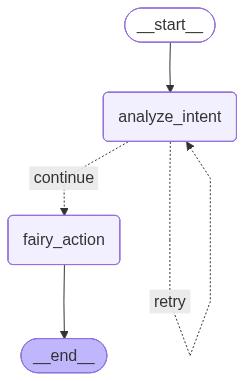

In [4]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

from agents.fairy.fairy_dungeon_agent import graph_builder as dungeon_graph_builder
dungeon_graph = dungeon_graph_builder.compile() 
dungeon_graph

In [20]:
from langgraph.checkpoint.memory import MemorySaver
from agents.fairy.util import add_human_message
from core.game_dto.z_muck_factory import MockFactory
from agents.fairy.fairy_state import DungeonPlayerState
import random

temp_player = DungeonPlayerState(
    playerId=999,
    heroineId=1,
    currRoomId=1,
    difficulty=random.randint(0, 2),
    hp = 250,
    moveSpeed = 1,
    attackSpeed = 1.0,
    weapon=MockFactory.create_weapon(),
    inventory=[0, 21, 42],
)
memory = MemorySaver()
graph = dungeon_graph_builder.compile(memory)

config = {"configurable": {"thread_id": "user_1"}}
inputs = {
    "messages": [add_human_message(content="현재 던전에 대해 설명해줘")],    
    "dungenon_player": temp_player,
    "target_monster_ids":[0,1]
}
result = await graph.ainvoke(inputs, config=config)

전체 의도:: intents=[<FairyDungeonIntentType.DUNGEON_NAVIGATOR: 'DUNGEON_NAVIGATOR'>]
check_prompt:: <사용 능력>
['DUNGEON_NAVIGATOR']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>
    <던전 안내>
        <던전맵>

아래는 현재 플레이어가 탐험 중인 던전의 전체 구조를 설명하는 데이터입니다.
던전은 방(room), 몬스터 스폰 정보, 보상 테이블 등으로 구성되며,
각 필드의 의미와 값의 범위는 다음 스펙을 참고하면 됩니다.

이 정보는 현재 위치한 방의 형태, 연결된 경로, 등장 가능한 몬스터,
획득 가능한 보상 등을 이해하는 데 사용됩니다.

■ playerIds (int[])
  - 던전에 참여한 플레이어 ID 목록

■ heroineIds (int[])
  - 각 플레이어가 선택한 히로인 ID 목록

■ rooms (roomData[])
  던전을 구성하는 방 목록입니다.

  ● roomId (int)
      각 방의 고유 ID

  ● type (int)
      방의 종류  

In [21]:
temp_player

DungeonPlayerState(playerId=999, heroineId=1, currRoomId=1, difficulty=2, hp=250, moveSpeed=1.0, attackSpeed=1.0, weapon=WeaponData(weaponId=22, weaponType=2, weaponName='레어 쌍검', rarity=2, attackPower=11, staggerPower=1, modifier={'strength': 0.1, 'dexterity': 0.8, 'intelligence': 0.1}), inventory=[0, 21, 42])

In [22]:
result['messages']

[HumanMessage(content='현재 던전에 대해 설명해줘', additional_kwargs={'created_at': '2025-12-05T17:58:53.172974'}, response_metadata={}, id='e62fc21d-6bbb-406b-a878-f6fd86dca154'),
 AIMessage(content='현재 던전은 5개의 방으로 구성되어 있어. 보스 방이 하나 있고, 빈 방과 이벤트 방이 각각 하나씩 있어. 몬스터가 있는 방도 두 개가 있어. 난이도는 전투력이 58.50이고, AI 배율은 0.7배야.', additional_kwargs={'created_at': '2025-12-05T17:58:54.681879', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='af40aebc-8998-4ff4-9b28-4a66836b27c1')]

In [8]:
await graph.ainvoke(
    { "messages": HumanMessage(content="저 몬스터 뭐야?") },
    config=config
)

전체 의도:: intents=[<FairyDungeonIntentType.MONSTER_GUIDE: 'MONSTER_GUIDE'>]
check_prompt:: <사용 능력>
['MONSTER_GUIDE']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>
    <몬스터 정보>
[{'monsterId': 0, 'monsterType': 0, 'monsterName': '스켈레톤', 'hp': 300, 'speed': 350, 'attack': 10, 'attackSpeed': 1, 'attackRange': 100, 'staggerGage': 10}, {'monsterId': 1, 'monsterType': 0, 'monsterName': '슬라임', 'hp': 250, 'speed': 200, 'attack': 10, 'attackSpeed': 1, 'attackRange': 100, 'staggerGage': 5}]
    </몬스터 정보>
</현재 상황>

위 정보와 시스템 프롬프트의 규칙을 모두 지키면서,
아래 사용자 발화에 대해 페이몬으로서 한 번만 답해줘.

- 시스템에서 정의된 말투/글

{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T17:58:18.384938'}, response_metadata={}, id='8983fde1-adaa-4593-822a-e6cf1c040fd9'),
  AIMessage(content='다음 방은 이벤트 방이야!', additional_kwargs={'created_at': '2025-12-05T17:58:19.855097', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='978ea009-ab8f-4e75-8ac1-dc3a1d2971fa'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='40fa6dc0-4a34-497c-8678-eba9cf5972b3'),
  AIMessage(content='스켈레톤과 슬라임이야!', additional_kwargs={'created_at': '2025-12-05T17:58:20.994326', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='6b1389c5-16c6-4691-a64b-6c11173b04b4')],
 'intent_types': [<FairyDungeonIntentType.MONSTER_GUIDE: 'MONSTER_GUIDE'>],
 'dungenon_player': DungeonPlayerState(playerId=999, heroineId=1, currRoomId=1, difficulty=2, hp=250, moveSpeed=1.0, attackSpeed=1.0, weapon=WeaponData(weaponId=22, weaponType=2, weaponName='레어 쌍검', rarity=2, 

In [9]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[]

In [10]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="나 체력 몇이라고 했었지?") },
    config=config
)

전체 의도:: intents=[<FairyDungeonIntentType.INTERACTION_HANDLER: 'INTERACTION_HANDLER'>]
check_prompt:: <사용 능력>
['INTERACTION_HANDLER']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>
    <상호작용>
        <인벤토리 내의 아이템 설명>
[ItemData(itemName='일반 한손검', itemId=0, itemType=1, rarity=0, weapon=WeaponData(weaponId=0, weaponType=1, weaponName='일반 한손검', rarity=0, attackPower=10, staggerPower=2, modifier={'strength': 0.7, 'dexterity': 0.3, 'intelligence': 0.0})), ItemData(itemName='고급 쌍검', itemId=21, itemType=2, rarity=1, weapon=WeaponData(weaponId=21, weaponType=2, weaponName='고급 쌍검', rarity=

In [11]:
from agents.fairy.util import get_small_talk_history
get_small_talk_history(result["messages"])

[]

In [12]:
await graph.ainvoke(
    { "messages": add_human_message(content="물약 사용해") },
    config=config
)

전체 의도:: intents=[<FairyDungeonIntentType.INTERACTION_HANDLER: 'INTERACTION_HANDLER'>]
check_prompt:: <사용 능력>
['INTERACTION_HANDLER']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>
    <상호작용>
        <인벤토리 내의 아이템 설명>
[ItemData(itemName='일반 한손검', itemId=0, itemType=1, rarity=0, weapon=WeaponData(weaponId=0, weaponType=1, weaponName='일반 한손검', rarity=0, attackPower=10, staggerPower=2, modifier={'strength': 0.7, 'dexterity': 0.3, 'intelligence': 0.0})), ItemData(itemName='고급 쌍검', itemId=21, itemType=2, rarity=1, weapon=WeaponData(weaponId=21, weaponType=2, weaponName='고급 쌍검', rarity=

{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T17:58:18.384938'}, response_metadata={}, id='8983fde1-adaa-4593-822a-e6cf1c040fd9'),
  AIMessage(content='다음 방은 이벤트 방이야!', additional_kwargs={'created_at': '2025-12-05T17:58:19.855097', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='978ea009-ab8f-4e75-8ac1-dc3a1d2971fa'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='40fa6dc0-4a34-497c-8678-eba9cf5972b3'),
  AIMessage(content='스켈레톤과 슬라임이야!', additional_kwargs={'created_at': '2025-12-05T17:58:20.994326', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='6b1389c5-16c6-4691-a64b-6c11173b04b4'),
  HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T17:58:21.002866'}, response_metadata={}, id='14a11b3e-d33d-4762-b15b-4ae4d01d0e0a'),
  AIMessage(content='체력은 250이야!', additional_kwargs={'created_at': '2025-12-05T17:58:22.155195', 'intent_types': ['

In [13]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="뭙야") },
    config=config
)
result

전체 의도:: intents=[<FairyDungeonIntentType.SMALLTALK: 'SMALLTALK'>]
check_prompt:: <사용 능력>
['SMALLTALK']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>

</현재 상황>

위 정보와 시스템 프롬프트의 규칙을 모두 지키면서,
아래 사용자 발화에 대해 페이몬으로서 한 번만 답해줘.

- 시스템에서 정의된 말투/글자수/능력 규칙을 그대로 따를 것.
- 답변은 JSON 같은 구조 없이, 자연스러운 대화형 한글 문장만 출력할 것.

[사용자 발화]
뭙야



{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T17:58:18.384938'}, response_metadata={}, id='8983fde1-adaa-4593-822a-e6cf1c040fd9'),
  AIMessage(content='다음 방은 이벤트 방이야!', additional_kwargs={'created_at': '2025-12-05T17:58:19.855097', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='978ea009-ab8f-4e75-8ac1-dc3a1d2971fa'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='40fa6dc0-4a34-497c-8678-eba9cf5972b3'),
  AIMessage(content='스켈레톤과 슬라임이야!', additional_kwargs={'created_at': '2025-12-05T17:58:20.994326', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='6b1389c5-16c6-4691-a64b-6c11173b04b4'),
  HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T17:58:21.002866'}, response_metadata={}, id='14a11b3e-d33d-4762-b15b-4ae4d01d0e0a'),
  AIMessage(content='체력은 250이야!', additional_kwargs={'created_at': '2025-12-05T17:58:22.155195', 'intent_types': ['

In [14]:
result = await graph.ainvoke(
    { "messages": add_human_message(content="게임 조작키좀 알려줘") },
    config=config
)
result["messages"][-1]

전체 의도:: intents=[<FairyDungeonIntentType.USAGE_GUIDE: 'USAGE_GUIDE'>]
check_prompt:: <사용 능력>
['USAGE_GUIDE']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>
    <사용 방법·조작 안내>

# 게임 시스템 개요

본 문서는 던전 탐사 중심의 게임 플레이 루프, 캐릭터 조작 방안,  
그리고 히로인·현자 NPC와의 상호작용 시스템을 포함한 주요 게임 메커니즘을 정리한 내용입니다.

---

# 1. 게임 핵심 순환 구조

게임은 다음과 같은 순환 구조를 기반으로 진행됩니다.

## 1-1. 던전 탐사
- 플레이어는 **로그라이크 방식의 던전**을 탐험합니다.
- 전투를 통해 스킬을 사용하고, 무기 및 장비를 강화하며 파밍을 진행합니다.

## 1-2. 경험치 및 기억의 조각 획득
- 탐험 과정에서 다양한 자원을 수집하고 경험치를 획득합니다.
- 전투와 선택 결과가 누적되어 **기억의 조각**이 생성됩니다.

## 1-3. 상담 및 대화 (기억의 조각 소비)
- 축적한 기억의 조각을 사용하여 히로인과 상담 및 대화

AIMessage(content='조작키는 W, A, S, D로 이동하고, 좌클릭으로 공격, 우클릭으로 회피, 스페이스바도 회피야!', additional_kwargs={'created_at': '2025-12-05T17:58:25.592300', 'intent_types': ['USAGE_GUIDE']}, response_metadata={}, id='b2ba471b-d31c-48f4-a417-5bb46afd89e1')

In [15]:
print(result["messages"][-1].content)

조작키는 W, A, S, D로 이동하고, 좌클릭으로 공격, 우클릭으로 회피, 스페이스바도 회피야!


In [16]:
result["messages"]

[HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T17:58:18.384938'}, response_metadata={}, id='8983fde1-adaa-4593-822a-e6cf1c040fd9'),
 AIMessage(content='다음 방은 이벤트 방이야!', additional_kwargs={'created_at': '2025-12-05T17:58:19.855097', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='978ea009-ab8f-4e75-8ac1-dc3a1d2971fa'),
 HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='40fa6dc0-4a34-497c-8678-eba9cf5972b3'),
 AIMessage(content='스켈레톤과 슬라임이야!', additional_kwargs={'created_at': '2025-12-05T17:58:20.994326', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='6b1389c5-16c6-4691-a64b-6c11173b04b4'),
 HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T17:58:21.002866'}, response_metadata={}, id='14a11b3e-d33d-4762-b15b-4ae4d01d0e0a'),
 AIMessage(content='체력은 250이야!', additional_kwargs={'created_at': '2025-12-05T17:58:22.155195', 'intent_types': ['INTERACTION_HANDLE

In [17]:
import os, sys
from pathlib import Path


src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))  
from agents.fairy.cache_data import reverse_questions
len(reverse_questions)

149

In [18]:
await graph.ainvoke(
    { "messages": HumanMessage(content="내가 맨 처음에 질문했던 내용은 뭐였지? ㅎㅎ") },
    config=config
)

전체 의도:: intents=[<FairyDungeonIntentType.SMALLTALK: 'SMALLTALK'>]
check_prompt:: <사용 능력>
['SMALLTALK']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>

</현재 상황>

위 정보와 시스템 프롬프트의 규칙을 모두 지키면서,
아래 사용자 발화에 대해 페이몬으로서 한 번만 답해줘.

- 시스템에서 정의된 말투/글자수/능력 규칙을 그대로 따를 것.
- 답변은 JSON 같은 구조 없이, 자연스러운 대화형 한글 문장만 출력할 것.

[사용자 발화]
내가 맨 처음에 질문했던 내용은 뭐였지? ㅎㅎ



{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T17:58:18.384938'}, response_metadata={}, id='8983fde1-adaa-4593-822a-e6cf1c040fd9'),
  AIMessage(content='다음 방은 이벤트 방이야!', additional_kwargs={'created_at': '2025-12-05T17:58:19.855097', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='978ea009-ab8f-4e75-8ac1-dc3a1d2971fa'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='40fa6dc0-4a34-497c-8678-eba9cf5972b3'),
  AIMessage(content='스켈레톤과 슬라임이야!', additional_kwargs={'created_at': '2025-12-05T17:58:20.994326', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='6b1389c5-16c6-4691-a64b-6c11173b04b4'),
  HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T17:58:21.002866'}, response_metadata={}, id='14a11b3e-d33d-4762-b15b-4ae4d01d0e0a'),
  AIMessage(content='체력은 250이야!', additional_kwargs={'created_at': '2025-12-05T17:58:22.155195', 'intent_types': ['

In [19]:
await graph.ainvoke(
    { "messages": HumanMessage(content="스켈레톤에 대해서 알려줘") },
    config=config
)

전체 의도:: intents=[<FairyDungeonIntentType.MONSTER_GUIDE: 'MONSTER_GUIDE'>]
check_prompt:: <사용 능력>
['MONSTER_GUIDE']
</사용 능력>

<히로인 정보>
{
  "playerId": 999,
  "heroineId": 1,
  "currRoomId": 1,
  "difficulty": 2,
  "hp": 250,
  "moveSpeed": 1.0,
  "attackSpeed": 1.0,
  "weapon": {
    "weaponId": 22,
    "weaponType": 2,
    "weaponName": "레어 쌍검",
    "rarity": 2,
    "attackPower": 11,
    "staggerPower": 1,
    "modifier": {
      "strength": 0.1,
      "dexterity": 0.8,
      "intelligence": 0.1
    }
  },
  "inventory": [
    0,
    21,
    42
  ]
}
</히로인 정보>

<현재 상황>
    <몬스터 정보>
[{'monsterId': 0, 'monsterType': 0, 'monsterName': '스켈레톤', 'hp': 300, 'speed': 350, 'attack': 10, 'attackSpeed': 1, 'attackRange': 100, 'staggerGage': 10}, {'monsterId': 1, 'monsterType': 0, 'monsterName': '슬라임', 'hp': 250, 'speed': 200, 'attack': 10, 'attackSpeed': 1, 'attackRange': 100, 'staggerGage': 5}]
    </몬스터 정보>
</현재 상황>

위 정보와 시스템 프롬프트의 규칙을 모두 지키면서,
아래 사용자 발화에 대해 페이몬으로서 한 번만 답해줘.

- 시스템에서 정의된 말투/글

{'messages': [HumanMessage(content='다음방에는 뭐가 있을까?', additional_kwargs={'created_at': '2025-12-05T17:58:18.384938'}, response_metadata={}, id='8983fde1-adaa-4593-822a-e6cf1c040fd9'),
  AIMessage(content='다음 방은 이벤트 방이야!', additional_kwargs={'created_at': '2025-12-05T17:58:19.855097', 'intent_types': ['DUNGEON_NAVIGATOR']}, response_metadata={}, id='978ea009-ab8f-4e75-8ac1-dc3a1d2971fa'),
  HumanMessage(content='저 몬스터 뭐야?', additional_kwargs={}, response_metadata={}, id='40fa6dc0-4a34-497c-8678-eba9cf5972b3'),
  AIMessage(content='스켈레톤과 슬라임이야!', additional_kwargs={'created_at': '2025-12-05T17:58:20.994326', 'intent_types': ['MONSTER_GUIDE']}, response_metadata={}, id='6b1389c5-16c6-4691-a64b-6c11173b04b4'),
  HumanMessage(content='나 체력 몇이라고 했었지?', additional_kwargs={'created_at': '2025-12-05T17:58:21.002866'}, response_metadata={}, id='14a11b3e-d33d-4762-b15b-4ae4d01d0e0a'),
  AIMessage(content='체력은 250이야!', additional_kwargs={'created_at': '2025-12-05T17:58:22.155195', 'intent_types': ['

# 몬스터 공략 (주로 보스몬스터 위주로)
 1. 현재방의 몬스터 상세 정보 필요 -> 상세정보 Search RAG (K = 1)
 2. 몬스터 찾기 멀티쿼리 필요 -> 사용자는 몬스터 명을 모를 확률이 큼 => 멀티쿼리로 현재방중 몬스터 특징에 따라 몬스터 찾기
 3. 몬스터 공략법 RAG 필요 -> 찾은 몬스터의 공략 해결책을 찾는 서칭 필요 

# 이벤트 공략 
 - 캐시 DB로부터 생성된 이벤트 정보 GET -> 힌트 위주로 제공 

# 던전 안내
 - 캐시 DB로 부터 생성된 던전의 전체 특징을 요약 후 브리핑 

# 인터렉션 
 - 방 불키기, 물약 사용, 아이템 사용 return 액션, 사용ID(Option)

# 멀티턴 전략 
 - 이전 대화 요약본 저장 
